In [88]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import bct
from CALM_utils import get_imaging_ID
import matplotlib.pyplot as plt
import networkfunctions
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from statsmodels import robust
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import ks_2samp, spearmanr, zscore, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from subprocess import call

In [5]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches
one_half_column = 140*mm2inches

In [6]:
def make_SuePlot(df, measures, binarized_results, labels, width, name):
    import itertools
    from matplotlib.colors import LinearSegmentedColormap

    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})
    colours = ['turquoise', 'gold', 'firebrick', 'limegreen', 'darkorange', 'deepskyblue']

    plt.figure(figsize=(width, double_column/2), dpi=600)

    plt.subplot(2,1,1)
    for community in np.unique(df['groups'].values):
        plt.errorbar(x=range(0,len(measures)),
                y=df[df['groups'] == community].median().values[1:],
                yerr=2*df[df['groups'] == community].std().values[1:]/sqrt(len(df[df['groups'] == community])),
                color=colours[community-1])

    plt.xlim([-1,len(measures)])
    plt.xticks(range(0,len(measures)))
    plt.legend(['C' + str(community) for community in np.unique(df['groups'].values) ], frameon=True, loc='best')
    plt.ylabel('z-score')
    ax = plt.gca()
    ax.set_xticklabels('', rotation=90);
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.subplot(2,1,2)
    combinations = list(itertools.combinations(np.unique(df['groups'].values), 2))

    new_style = {'grid': False}
    matplotlib.rc('axes', **new_style)
    plt.imshow(binarized_results, 
              interpolation = 'none', 
              cmap=LinearSegmentedColormap.from_list('mycmap', [(0, 'lightgray'), (1, 'orangered')]))
    plt.yticks(np.arange(0,len(combinations)))
    plt.xticks(np.arange(0, len(measures)))
    plt.ylabel('contrast results')

    ax = plt.gca()
    ax.set_yticklabels([str(combination[0]) + ' v ' + str(combination[1]) for combination in combinations], rotation=0);
    ax.set_xticklabels(labels, rotation=90);
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig(outfolder + 'Sue_plot' + name + '.png', dpi=300)

In [7]:
in_folder = '/imaging/jb07/CALM/Modularity/connectome/'

In [8]:
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
behavioural_df = df.copy()
behavioural_df['MRI.ID'] = [get_imaging_ID(str(ID)) for ID in behavioural_df['ID'].values]

## Getting the available MRI data

In [383]:
MRI_folder = '/imaging/jb07/CALM/CALM_BIDS/'
anat_df = pd.read_csv('/imaging/jb07/CALM/T1/T1_useable_data.csv')
dwi_df = pd.read_csv('/imaging/jb07/CALM/DWI/motion_estimation/Displacement_Results.csv')
dwi_df.columns = ['MRI.ID', 'displacement', 'volumes']
dwi_df = dwi_df[(dwi_df['volumes'] == 69)]
subject_list = np.unique(np.hstack([anat_df['MRI.ID'].values, dwi_df['MRI.ID'].values]))

dwi_df = dwi_df[dwi_df['MRI.ID'].isin(behavioural_df['MRI.ID'].values)]
anat_df = anat_df[anat_df['MRI.ID'].isin(behavioural_df['MRI.ID'].values)]

In [ ]:
print('Number of participants with MRI data available: ' + str(behavioural_df[behavioural_df['MRI.ID'].isin(subject_list)].shape[0]))

Removing dataset with excessive movement in the diffusion sequence or non-useable T1 data

In [ ]:
dwi_df = dwi_df[dwi_df['displacement'] < 3]
print('Number with useable dwi sequence:' + str(len(dwi_df)))

anat_df = anat_df[anat_df['useable'] == 1]
print('Number with useable T1 sequence:' + str(len(anat_df)))

df = pd.merge(dwi_df, anat_df, on='MRI.ID')
print('Number of participants with MRI data available: ' + str(len(df)))

In [ ]:
df = pd.merge(df, behavioural_df, on='MRI.ID')
df['group1'] = 1*(df['groups'] == 1)
df['group2'] = 1*(df['groups'] == 2)
df['group3'] = 1*(df['groups'] == 3)

## Running the connectome pipeline

In [26]:
infolder = '/imaging/jb07/CALM/CALM_BIDS/'
outfolder = '/imaging/jb07/CALM/Modularity/'
subject_list = sorted([subject for subject in df['MRI.ID'].values if not os.path.isfile(outfolder + 'connectome/_subject_id_' + subject + '/_model_CSD/_threshold_0/calc_matrix/mapflow/_calc_matrix0/' + subject + '_FA_matrix.txt')])

In [12]:
count = 0

for subject in subject_list:
    cmd = 'echo python /home/jb07/joe_python/GitHub/Modularity/connectome_pipeline.py ' + '--base_directory /imaging/jb07/CALM/CALM_BIDS/ ' + '--out_directory /imaging/jb07/CALM/Modularity/ ' + '--template_directory /home/jb07/joe_python/GitHub/Structural_Covariance/NKI/ ' + '--parcellation_directory /home/jb07/joe_python/GitHub/Structural_Covariance/FreeSurfer_templates/ ' + '--acquisition_parameters /imaging/jb07/CALM/CALM_BIDS/acqparams.txt ' + '--index_file /imaging/jb07/CALM/CALM_BIDS/index.txt ' + '--subject_list ' + subject + ',' + \
    ' > /home/jb07/Desktop/cluster_jobs/' + subject + '_new_connectome.sh'
    call(cmd, shell=True)
    cmd = 'qsub /home/jb07/Desktop/cluster_jobs/' + subject + '_new_connectome.sh -l walltime=48:00:00'
    call(cmd, shell=True)

## Implementation of the Nature Protocols approach

In [27]:
def run_nature_protocol(networks):
    for scale in ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']:
        pvalues = list()

        for node0 in np.arange(0, networks.shape[0]):
            for node1 in np.arange(0, networks.shape[1]):

                new_df = pd.DataFrame()
                new_df['scale'] = df[scale].values
                new_df['connection_strength'] = networks[node0, node1,...]

                r,p = spearmanr(new_df['scale'].values, new_df['connection_strength'].values)

                if r < 0:
                    pvalues.append(p)
                else:
                    pvalues.append(1)

        pvalues = np.asarray(pvalues)
        pvalues[np.isnan(pvalues)] = 1

        i,j = np.where(np.reshape(pvalues, newshape=[networks.shape[0], networks.shape[1]]) < 0.05)
        df['mean_value'] = np.mean(networks[i,j,:], axis=0)
        df[scale + '_weight'] = zscore(np.mean(networks[i,j,:], axis=0))

        binarized_network = np.zeros(shape=networks.shape[0:2])
        binarized_network[i,j] = 1
        np.savetxt(outfolder + scale + '_sign_neg_connections.edge', binarized_network)

    # Running an ANOVA to see if there is a group by scale interaction
    anova_df = df[['Inattention_weight', 'HyperactImpuls_weight', 'LearnProb_weight', 'ExeFunc_weight', 'Aggression_weight', 'PeerRel_weight', 'groups']]
    anova_df = pd.melt(anova_df, id_vars='groups')
    anova_df.columns = ['group', 'scale', 'weight']

    cw = smf.ols('weight ~ C(group) + C(scale) + C(group)*C(scale)', data=anova_df).fit()
    print(sm.stats.anova_lm(cw, typ=2))

    # Running contrasts 
    scales = ['Inattention_weight', 'HyperactImpuls_weight', 'LearnProb_weight', 'ExeFunc_weight', 'Aggression_weight', 'PeerRel_weight']
    pvalues = list()

    for group in [(1,2), (1,3), (2,3)]:
        for scale in scales:
            group1 = anova_df[(anova_df['group'] == group[0]) & (anova_df['scale'] == scale)]['weight'].values
            group2 = anova_df[(anova_df['group'] == group[1]) & (anova_df['scale'] == scale)]['weight'].values
            pvalues.append(ks_2samp(group1, group2)[1])

    accept, corrected_p, _, _ = multipletests(pvalues, alpha=0.05, method='bonferroni')

    results_df = pd.DataFrame(np.reshape(accept, newshape=[3,6]))
    results_df.columns = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
    results_df.index = ['1 v 2', '1 v 3', '2 v 3']
    print(results_df)

    # Creating an overview plot showing the results
    anova_df = df[np.hstack([scales, ['groups']])]
    labels = ['Inattention', 'HyperactImpuls', 'LearnProb', 'ExeFunc', 'Aggression', 'PeerRel']
    make_SuePlot(anova_df, scales, np.reshape(accept, newshape=[3,6]), labels, single_column, 'test')
    plt.show()
    
    return anova_df, corrected_p

## Analysis of the structural networks

In [31]:
aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc.nii.gz') 
coordinates = np.loadtxt('/home/jb07/Desktop/DK_coordinates.txt')
coordinates = coordinates[aparc_indices]
coordinates_df = pd.DataFrame()
coordinates_df['x'] = coordinates[..., 0]
coordinates_df['y'] = coordinates[..., 1]
coordinates_df['z'] = coordinates[..., 2]
coordinates_df['colour'] = np.ones(coordinates.shape[0])
coordinates_df['size'] = np.ones(coordinates.shape[0])
coordinates_df['labels'] = [line.split()[0] for line in open('/home/jb07/Desktop/labels.txt', 'r')]
coordinates_df.to_csv('/home/jb07/Desktop/DK_nodes.node', header=False, index=False, sep=' ')

                         sum_sq   df             F    PR(>F)
C(group)           6.756423e+00    2  3.443187e+00  0.032503
C(scale)           7.530143e-29    5  1.534995e-29  1.000000
C(group):C(scale)  2.449079e+01   10  2.496184e+00  0.006013
Residual           6.887528e+02  702           NaN       NaN
      Inattention HyperactImpuls LearnProb ExeFunc Aggression PeerRel
1 v 2       False          False     False   False      False   False
1 v 3       False          False     False   False      False   False
2 v 3       False           True     False   False      False   False


/home/jb07/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


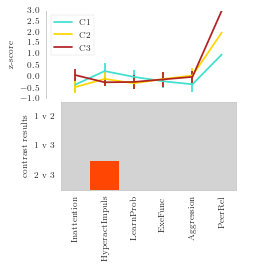

In [32]:
# Loading the data
filename = lambda(subject): in_folder + '_subject_id_' + subject + '/_model_CSA/_threshold_10/calc_matrix/mapflow/_calc_matrix0/' + subject + '_FA_matrix.txt'
subject_list = sorted([subject for subject in df['MRI.ID'].values if os.path.isfile(filename(subject))])
df = df[df['MRI.ID'].isin(subject_list)]
networks = np.rollaxis(np.asarray([np.loadtxt(filename(subject)) for subject in subject_list]), 0, 3)
np.place(networks, np.isnan(networks), 0) # replacing nan values

# Removing regions that are not of interest
aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc_expanded.nii.gz')
new_networks = list()

for counter in range(0,networks.shape[2]):
    network = networks[..., counter]
    network = network[aparc_indices, ...]
    network = network[..., aparc_indices]
    new_networks.append(np.squeeze(network))

networks = np.rollaxis(np.asarray(new_networks), 0, 3)

# Running the Nature protocol
results_df, corrected_p = run_nature_protocol(networks)

/home/jb07/python_modules/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


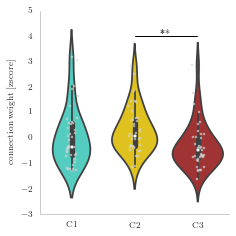

In [231]:
pvalue = 0.009
scale = 'HyperactImpuls'

sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

fig = plt.figure(figsize=(single_column, single_column), dpi=300, tight_layout=True)
colours = ['#40E0D0', '#FFD700', '#b22222']
results_df['groups'] = pd.Categorical(results_df['groups'].values, categories=[1,2,3], ordered=True)
plt.axhline(y=4, xmin=0.5, xmax=0.83, color='k', linewidth=1)

sns.violinplot(x='groups', y=scale + '_weight', palette=colours, data=results_df)
sns.stripplot(x='groups', y=scale + '_weight', color='k', alpha=0.6, size=1.5, jitter=True, data=results_df)
plt.xlabel(' ')
plt.ylabel('connection weight [zscore]')

if pvalue < 0.05:
    plt.text(1.4, 4.1, '*')
    
if pvalue < 0.01:
    plt.text(1.4, 4.1, '**')
    
if pvalue < 0.001:
    plt.text(1.4, 4.1, '***')

ax = fig.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['C1', 'C2', 'C3'])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.savefig(outfolder + '/' + scale + '_neg.png', dpi=600)

In [256]:
group1 = results_df[results_df['groups'] == 1]['HyperactImpuls_weight'].values
group2 = results_df[results_df['groups'] == 2]['HyperactImpuls_weight'].values
group3 = results_df[results_df['groups'] == 3]['HyperactImpuls_weight'].values

print('C1: median=%.2f, mad=%.3f;' %(np.median(group1), robust.mad(group1)))
print('C2: median=%.2f, mad=%.3f;' %(np.median(group2), robust.mad(group2)))
print('C3: median=%.2f, mad=%.3f;' %(np.median(group3), robust.mad(group3)))

group1 = results_df[results_df['groups'] == 2]['HyperactImpuls_weight'].values
group2 = results_df[results_df['groups'] == 3]['HyperactImpuls_weight'].values
H,p = ks_2samp(group1, group2)

print('Kruskal-Wallis test: H=%.2f, p=%.3f' % (H,p))

C1: median=-0.37, mad=0.992;
C2: median=0.06, mad=0.770;
C3: median=-0.48, mad=0.624;
Kruskal-Wallis test: H=0.44, p=0.001


## Graph analysis within the associated connections

In [261]:
connection_mask = np.loadtxt(outfolder + 'HyperactImpuls_sign_neg_connections.edge')

In [268]:
node_mask = np.unique(np.where(connection_mask == 1))

In [285]:
degrees = list()
clustering_coefficient = list()
betweenness_centrality = list()

for i in range(0, networks.shape[2]):
    network = networks[..., i]
    degrees.append(np.mean(bct.degrees_und(networks[..., 0])[node_mask]))
    clustering_coefficient.append(np.mean(bct.clustering_coef_wu(network)[node_mask]))
    betweenness_centrality.append(np.mean(bct.betweenness_wei(network)[node_mask]))

In [311]:
df['degree'] = degrees
df['clustering_coeffcient'] = clustering_coefficient
df['betweenness_centrality'] = [float(value)/((network.shape[0]-1)*(network.shape[0]-2)) for value in betweenness_centrality]

In [314]:
for contrast in ['degree', 'clustering_coeffcient', 'betweenness_centrality']:
    group1 = df[results_df['groups'] == 1][contrast].values
    group2 = df[results_df['groups'] == 2][contrast].values
    group3 = df[results_df['groups'] == 3][contrast].values
    
    print(contrast)
    print('C1: median=%.2f, mad=%.3f;' %(np.median(group1), robust.mad(group1)))
    print('C2: median=%.2f, mad=%.3f;' %(np.median(group2), robust.mad(group2)))
    print('C3: median=%.2f, mad=%.3f;' %(np.median(group3), robust.mad(group3)))

    group1 = df[df['groups'] == 2][contrast].values
    group2 = df[df['groups'] == 3][contrast].values
    H,p = ks_2samp(group1, group2)

    print('Kruskal-Wallis test: H=%.2f, p=%.3f' % (H,p))
    print('\n')

degree
C1: median=4.29, mad=0.000;
C2: median=4.29, mad=0.000;
C3: median=4.29, mad=0.000;
Kruskal-Wallis test: H=0.00, p=1.000


clustering_coeffcient
C1: median=0.09, mad=0.022;
C2: median=0.09, mad=0.036;
C3: median=0.09, mad=0.027;
Kruskal-Wallis test: H=0.15, p=0.759


betweenness_centrality
C1: median=0.03, mad=0.006;
C2: median=0.03, mad=0.007;
C3: median=0.03, mad=0.004;
Kruskal-Wallis test: H=0.27, p=0.092




## Results table of connections within the Hyperact/Impuls network

In [33]:
scale = 'HyperactImpuls'
pvalues = list()

for node0 in np.arange(0, networks.shape[0]):
    for node1 in np.arange(0, networks.shape[1]):

        new_df = pd.DataFrame()
        new_df['scale'] = df[scale].values
        new_df['connection_strength'] = networks[node0, node1,...]

        r,p = spearmanr(new_df['scale'].values, new_df['connection_strength'].values)

        if r < 0:
            pvalues.append(p)
        else:
            pvalues.append(1)

pvalues = np.asarray(pvalues)
pvalues[np.isnan(pvalues)] = 1

i,j = np.where(np.reshape(pvalues, newshape=[networks.shape[0], networks.shape[1]]) < 0.05)

In [105]:
sign_pvalues = np.reshape(pvalues, newshape=[networks.shape[0], networks.shape[1]])[np.where(np.reshape(pvalues, newshape=[networks.shape[0], networks.shape[1]]) < 0.05)]
mean_FA = np.mean(networks[i,j, ...], axis=1)
std_FA = np.std(networks[i,j, ...], axis=1)

labels = pd.read_csv('/imaging/jb07/CALM/Modularity/labels.txt', header=None)[0].values
connections = labels[i] + '-' + labels[j]

results = pd.DataFrame()
results['mean FA'] = mean_FA
results['std FA'] = std_FA
results['p'] = sign_pvalues
results.index = connections
results = results.round({'mean FA': 2, 'std FA': 3, 'p': 3})
results = results.sort_index()

In [106]:
print(results.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  mean FA &  std FA &      p \\
\midrule
lh-amygdala-lh-thalamus                 &     0.02 &   0.093 &  0.043 \\
lh-bankssts-lh-inferiorparietal         &     0.02 &   0.099 &  0.006 \\
lh-bankssts-lh-superiortemporal         &     0.09 &   0.187 &  0.020 \\
lh-caudate-lh-superiorparietal          &     0.16 &   0.201 &  0.028 \\
lh-caudate-lh-thalamus                  &     0.35 &   0.266 &  0.023 \\
lh-fusiform-lh-inferiortemporal         &     0.03 &   0.117 &  0.031 \\
lh-inferiorparietal-lh-bankssts         &     0.02 &   0.099 &  0.006 \\
lh-inferiortemporal-lh-fusiform         &     0.03 &   0.117 &  0.031 \\
lh-inferiortemporal-lh-superiorparietal &     0.08 &   0.182 &  0.043 \\
lh-ippocampus-lh-pericalcarine          &     0.11 &   0.203 &  0.010 \\
lh-lingual-lh-rostralmiddlefrontal      &     0.02 &   0.082 &  0.024 \\
lh-middletemporal-lh-putamen            &     0.15 &   0.213 &  0.048 \\
lh-pallidum-lh-rostralmiddlefrontal     &     0.

In [102]:
?results_df.sort_index

## Running a TBSS analysis

In [29]:
import shutil

In [30]:
folder = '/imaging/jb07/CALM/Modularity/connectome/'
filename = lambda subject: folder + '_subject_id_' + subject + '/dwi_preproc/dtifit/' + subject + '_FA.nii.gz'
mask_filename = lambda subject: folder + '_subject_id_' + subject + '/erode_mask/' + subject + '_mask_ero.nii.gz'
subject_list = sorted([subject.split('_')[-1] for subject in os.listdir(folder) if os.path.isfile(filename(subject.split('_')[-1]))])

In [27]:
behavioural_df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
behavioural_df['MRI.ID'] = [get_imaging_ID(str(ID)) for ID in behavioural_df['ID'].values]
behavioural_df = behavioural_df[behavioural_df['MRI.ID'].isin(subject_list)]

In [46]:
out_folder = '/imaging/jb07/CALM/Modularity/TBSS/FA/'

for ID in behavioural_df['MRI.ID'].values:
    shutil.copyfile(filename(ID), out_folder + ID + '_FA.nii.gz')
    shutil.copyfile(mask_filename(ID), out_folder + ID + '_FA_mask.nii.gz')

### Running TBSS steps

In [47]:
cmd = 'cd /imaging/jb07/CALM/Modularity/TBSS/ \n' + os.environ['FSLDIR'] + '/bin/tbss_2_reg -t /imaging/jb07/CALM/CALM_template.nii.gz' 
file = open('/home/jb07/Desktop/cluster_jobs/tbss_2.sh', 'w')
file.write(cmd)
file.close()

cmd = 'qsub /home/jb07/Desktop/cluster_jobs/tbss_2.sh'
call(cmd, shell=True)

0

In [127]:
cmd = 'cd /imaging/jb07/CALM/Modularity/TBSS/ \n' + os.environ['FSLDIR'] + '/bin/tbss_3_postreg -S' 
file = open('/home/jb07/Desktop/cluster_jobs/tbss_3.sh', 'w')
file.write(cmd)
file.close()

cmd = 'qsub /home/jb07/Desktop/cluster_jobs/tbss_3.sh'
call(cmd, shell=True)

0

In [154]:
cmd = 'cd /imaging/jb07/CALM/Modularity/TBSS/ \n' + os.environ['FSLDIR'] + '/bin/tbss_4_prestats 0.2' 
file = open('/home/jb07/Desktop/cluster_jobs/tbss_4.sh', 'w')
file.write(cmd)
file.close()

cmd = 'qsub /home/jb07/Desktop/cluster_jobs/tbss_4.sh'
call(cmd, shell=True)

0

Getting the group assocations

In [385]:
folder = '/imaging/jb07/CALM/Modularity/TBSS/FA/'
subject_list = sorted([subject.split('_')[0] for subject in os.listdir(folder) if re.search('_FA.nii.gz', subject)])

In [390]:
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
df['MRI.ID'] = [get_imaging_ID(str(ID)) for ID in df['ID'].values]
df = df.dropna()

In [426]:
df = df[df['MRI.ID'].isin(subject_list)]
#np.vstack([1*(df['groups'] == 3).values, 1*(df['groups'] != 3).values]).transpose()

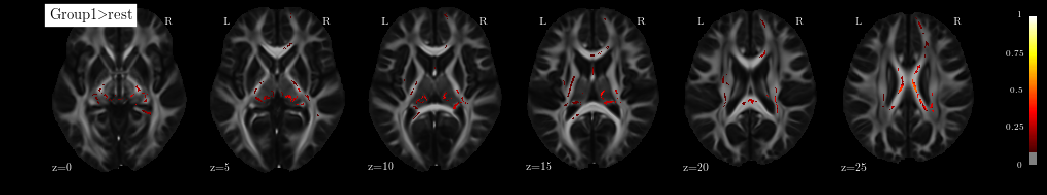

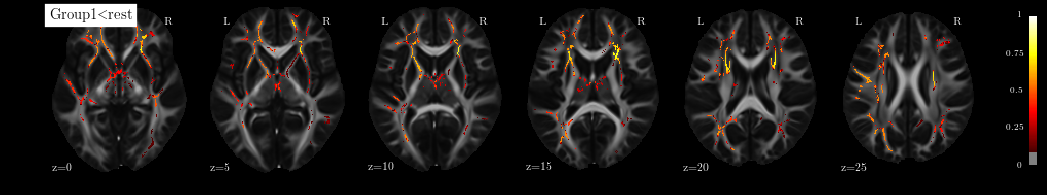

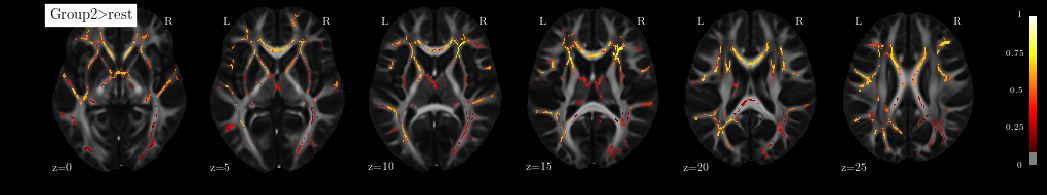

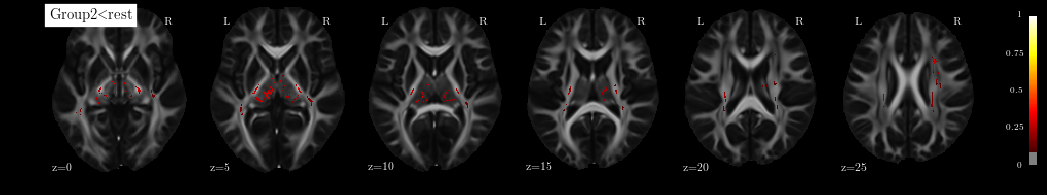

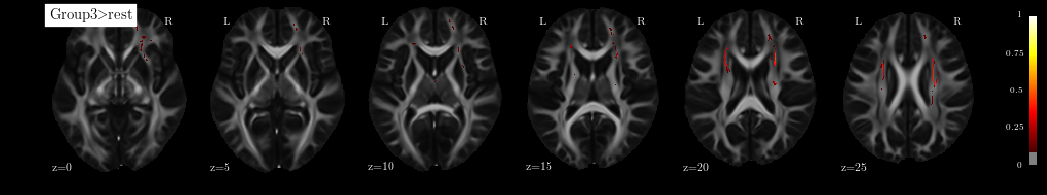

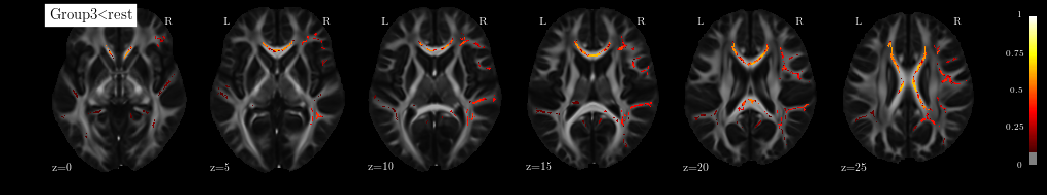

In [425]:
from nilearn import plotting
groups = [1,2,3]
contrasts = ['tstat1', 'tstat2']

for group in groups:
    for contrast in contrasts:
        stat_image = '/imaging/jb07/CALM/Modularity/TBSS/stats/Group' + str(group) + '_tfce_corrp_' + contrast + '.nii.gz'
        background = '/imaging/jb07/CALM/CALM_template.nii.gz'

        if contrast == 'tstat1':
            title = 'Group' + str(group) + '$>$rest'
        else:
            title = 'Group' + str(group) + '$<$rest'

        plotting.plot_stat_map(stat_image,
                               bg_img=background,
                               display_mode = 'z',
                               cut_coords = [0, 5, 10, 15, 20, 25],
                               threshold=0.1, vmax=1, title=title,
                               dim=1)
        plt.savefig('/imaging/jb07/CALM/Modularity/TBSS/Group' +  str(group) + '_' + contrast + '.png',dpi=600)

In [413]:
?plotting.plot_stat_map

## Running the analysis with PLS

In [110]:
from scipy.stats import sem, zscore
from sklearn.cross_decomposition import PLSRegression

In [48]:
aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc.nii.gz') 
coordinates = np.loadtxt('/home/jb07/Desktop/DK_coordinates.txt')
coordinates = coordinates[aparc_indices]
coordinates_df = pd.DataFrame()
coordinates_df['x'] = coordinates[..., 0]
coordinates_df['y'] = coordinates[..., 1]
coordinates_df['z'] = coordinates[..., 2]
coordinates_df['colour'] = np.ones(coordinates.shape[0])
coordinates_df['size'] = np.ones(coordinates.shape[0])
coordinates_df['labels'] = [line.split()[0] for line in open('/home/jb07/Desktop/labels.txt', 'r')]
coordinates_df.to_csv('/home/jb07/Desktop/DK_nodes.node', header=False, index=False, sep=' ')

In [60]:
# Loading the data
filename = lambda(subject): in_folder + '_subject_id_' + subject + '/_model_CSA/_threshold_10/calc_matrix/mapflow/_calc_matrix0/' + subject + '_FA_matrix.txt'
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
df['MRI.ID'] = [get_imaging_ID(str(ID)) for ID in df['ID'].values]
df = df.dropna()
subject_list = sorted([subject for subject in df['MRI.ID'].values if os.path.isfile(filename(subject))])
df = df[df['MRI.ID'].isin(subject_list)]
networks = np.rollaxis(np.asarray([np.loadtxt(filename(subject)) for subject in subject_list]), 0, 3)
np.place(networks, np.isnan(networks), 0) # replacing nan values

# Removing regions that are not of interest
aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc_expanded.nii.gz')
new_networks = list()

for counter in range(0,networks.shape[2]):
    network = networks[..., counter]
    network = network[aparc_indices, ...]
    network = network[..., aparc_indices]
    new_networks.append(np.squeeze(network))

networks = np.rollaxis(np.asarray(new_networks), 0, 3)

In [98]:
degrees = list()

for i in range(0, networks.shape[2]):
    degrees.append(bct.degrees_und(bct.threshold_proportional(networks[...,i], 0.9)))

degrees = np.asarray(degrees)

In [179]:
df['group1'] = 1*(df['groups'] == 1)
df['group2'] = 1*(df['groups'] == 2)
df['group3'] = 1*(df['groups'] == 3)

x_original = np.asarray(degrees)
y_original = df[['group1', 'group2', 'group3']].values

Determine the optimal number of components

In [322]:
number_of_components = 10

variances = list()
variances_std = list()

for components in range(1,number_of_components):
    x_loadings = list()
    variance_explained = list()
    
    for i in range(0,1000):
        # Selecting a random sub-sample (60% of the total sample)
        random_indices = np.asarray(sorted(np.random.choice(np.arange(0,x_original.shape[0]), int(round(0.6*x_original.shape[0])))))
        x_sample = x_original[np.asarray(random_indices), :]
        y_sample = y_original[np.asarray(random_indices), :]

        # Running PLS regression on the random sample
        pls = PLSRegression(n_components=components)
        fit = pls.fit(x_sample, y_sample)

        # Collecting the results
        x_loadings.append(fit.x_loadings_)
        variance_explained.append(pls.score(X=x_sample, y=y_sample))
    
    variances.append( 100*np.mean(variance_explained))
    variances_std.append(100*np.std(variance_explained))
    
    
results = pd.DataFrame()
results['component_variance'] = np.hstack([variances[0], np.diff(variances)])
results['cumulative_variance'] = variances
results['component_variance_std'] = variances_std
results.index = ['component ' + str(i) for i in range(1,number_of_components)]
print(results.round({'component_variance': 2, 'cumulative_variance': 2, 'component_variance_std': 3}))

             component_variance  cumulative_variance  component_variance_std
component 1               22.38                22.38                   4.294
component 2               18.07                40.45                   6.341
component 3                9.43                49.87                   4.212
component 4                5.22                55.09                   4.381
component 5                4.48                59.57                   4.446
component 6                2.26                61.83                   4.553
component 7                1.34                63.17                   4.946
component 8                0.39                63.56                   5.360
component 9               -0.42                63.13                   6.077


Compare the groups running PLS with the optimal number of components

In [317]:
pls = PLSRegression(n_components=5)
fit = pls.fit(x_original, y_original)
x_scores = fit.x_scores_

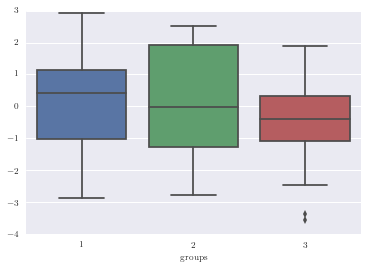

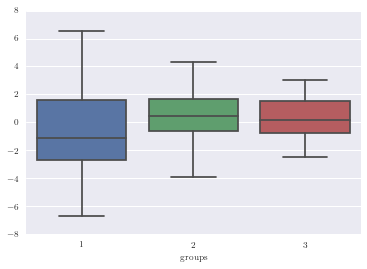

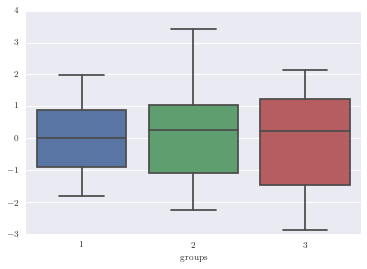

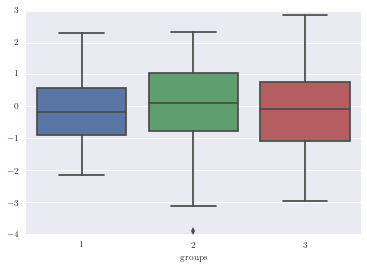

In [374]:
for i in range(0,4):
    sns.boxplot(df['groups'], x_scores[:,i])
    plt.show()

In [379]:
number_of_components = 5
results = pd.DataFrame()

for component in range(0, number_of_components):
    for comparison in [(1,2), (1,3), (2,3)]:
        W, p = ttest_ind(x_scores[np.where(df['groups'] == comparison[0]), component][0], x_scores[np.where(df['groups'] == comparison[1]), component][0])
        results.set_value(component, 'G' + str(comparison[0]) + ' vs G' + str(comparison[1]), p)

In [381]:
x_scores[np.where(df['groups'] == comparison[0]), component]

array([[ 0.48596519, -0.38567501, -0.49963614, -0.97566617,  0.69916455,
        -0.41002578, -2.12578893, -1.42290626, -1.09431097,  0.32606516,
        -1.55995848, -1.43246074, -1.30303082,  0.49691709,  1.57937013,
         0.84965838, -1.23362544,  0.46396843,  3.32258707,  0.44340504,
        -2.38194078, -1.90657017,  0.81724944, -0.79318157,  0.86218655,
        -0.29057706,  0.04446825,  0.58388269, -0.8154046 , -1.05528348,
        -2.10872072, -1.34571072, -1.10681399, -2.39762436, -2.22122207,
         1.16921837,  0.19438548, -0.23873227, -1.11241535, -0.55017313,
        -1.01201291,  1.15750462,  0.0400219 , -0.53716951,  1.06236309,
         2.91404693, -1.34250028, -1.66324365, -4.07046173, -0.46556086]])

In [380]:
print(results.round(3))

   G1 vs G2  G1 vs G3  G2 vs G3
0     0.000     0.000     0.002
1     0.329     0.000     0.002
2     0.000     0.440     0.000
3     0.000     0.204     0.010
4     0.027     0.351     0.003


In [377]:
_,p,_,_ = multipletests(results.values.flatten())
counter = 0

corrected_results = pd.DataFrame()
for component in range(0, number_of_components):
    for comparison in [(1,2), (1,3), (2,3)]:
        corrected_results.set_value(component, 'G' + str(comparison[0]) + ' vs G' + str(comparison[1]), p[counter])
        counter += 1

In [378]:
print(corrected_results.round(3))

   G1 vs G2  G1 vs G3  G2 vs G3
0     0.007     0.000     0.099
1     0.826     0.022     0.099
2     0.000     0.529     0.000
3     0.000     0.451     0.021
4     0.077     0.826     0.069


In [372]:
mean_loadings = np.mean(np.rollaxis(np.asarray(x_loadings), 0, 3), axis=2)
se_loadings = sem(np.rollaxis(np.asarray(x_loadings), 0, 3), axis=2)
pls_score = mean_loadings#*se_loadings
np.savetxt('/imaging/jb07/CALM/Modularity/PLS_scores.txt', pls_score)